# FEATURES ENGINEERING - MARKET REGIME

Understanding **market regimes** is essential for traders and quants to adapt strategies to different market conditions. Identifying whether the market is trending or ranging helps filter signals and optimize risk management.

In this notebook, we will explore **market regime detection techniques** using the `quantreo` package. 

**Tips: Market regime detection is often used as a filter for trend-following or mean-reversion strategies. Combining regimes with volatility or momentum filters can significantly reduce noise and improve model performance.**


In [1]:
# Import the Features Engineering Package from Quantreo
import quantreo.features_engineering as fe

# To display the graphics
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
# Import a dataset to test the functions and create new ones easily
from quantreo.datasets import load_generated_ohlcv

df = load_generated_ohlcv()
df = df.loc["2016"]

# Show the data
df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

## Kama Market Regime

The `kama_market_regime` function generates a **market regime indicator** based on the relative position of two Kaufman's Adaptive Moving Averages (KAMA): a fast KAMA and a slow KAMA.

This method is inspired by the traditional **moving average crossover logic**, but with the adaptivity of KAMA smoothing.

**Tip**: The choice of `l1`, `l2`, and `l3` parameters for each KAMA influences both **trend reactivity** and **noise filtering**. For trend-following strategies, using `l1_fast = 50` and `l1_slow = 200` is common, but you can adjust them depending on your timeframe.


In [9]:
df["kama_trend"] = fe.market_regime.kama_market_regime(df, "close", l1_fast=50, l2_fast=2, l3_fast=30,
                                                       l1_slow=200, l2_slow=2, l3_slow=30)
df["kama_trend"]

time
2016-01-04 00:00:00   -1
2016-01-04 04:00:00   -1
2016-01-04 08:00:00   -1
2016-01-04 12:00:00   -1
2016-01-04 16:00:00   -1
                      ..
2016-12-30 04:00:00    1
2016-12-30 08:00:00    1
2016-12-30 12:00:00    1
2016-12-30 16:00:00    1
2016-12-30 20:00:00    1
Name: kama_trend, Length: 1548, dtype: int64

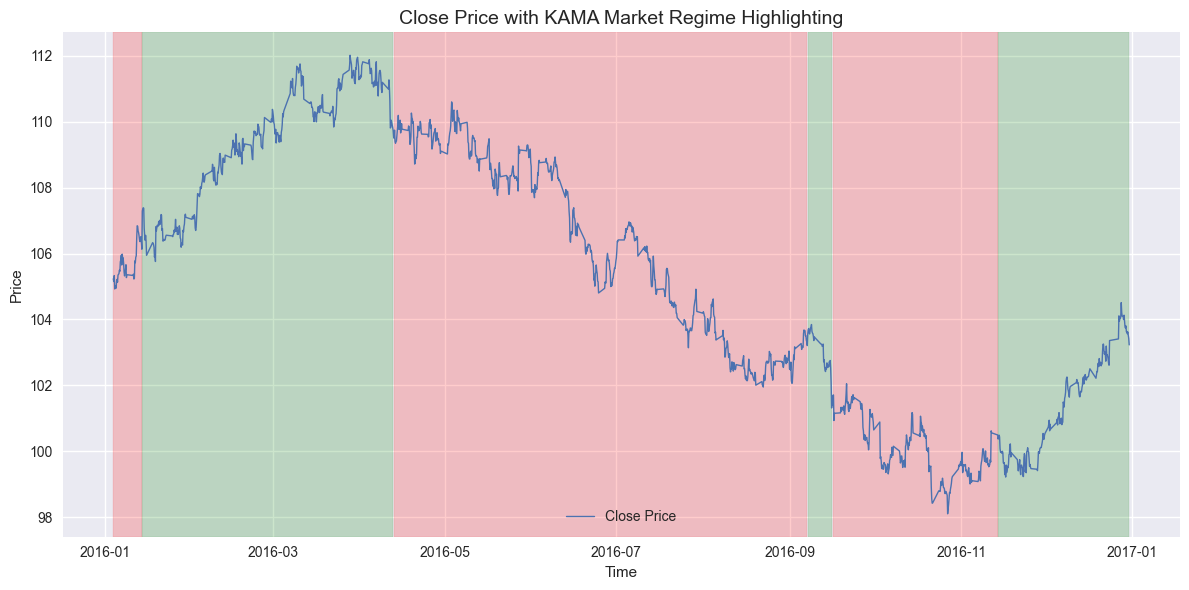

In [8]:
# Highlight market regimes using KAMA trend signals
import matplotlib.pyplot as plt

# Prepare data and detect regime shifts
dft = df[["kama_trend", "close"]].dropna().assign(time=lambda x: x.index)
dft["zone_id"] = dft["kama_trend"].ne(dft["kama_trend"].shift()).cumsum()

# Aggregate start, end, and regime label for each zone
zones = dft.groupby('zone_id').agg(
    start=('time', 'first'),
    end=('time', 'last'),
    regime=('kama_trend', 'first')
)

# Plot price with regime background coloring
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dft.index, dft['close'], label='Close Price', linewidth=1)

for _, row in zones.iterrows():
    color = 'green' if row['regime'] == 1 else 'red'
    ax.axvspan(row['start'], row['end'], color=color, alpha=0.2)

ax.set_title("Close Price with KAMA Market Regime Highlighting", fontsize=14)
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.tight_layout()
plt.show()